# Jet, Thickness, SLP, and ?Moisture Map?
http://www.atmos.albany.edu/student/heathera/2016.html
 The Thickness, SLP, and Moisture map contains
    - 250-hPa wind speed (m s^-1, shaded according to the color bar)
    - 1000-500-hPa thickness (dashed contours every 6 dam)
    - SLP (solid contours every 4 hPa)
    - total precipitable water (mm, shaded according to gray scale)



 http://apps.ecmwf.int/codes/grib/param-db
 #### Parameters from ECMWF
    - name = 'U component of wind',        shortName = 'u',      [m s^-1]
    - name = 'V component of wind',        shortName = 'v',      [m s^-1]
    - name = 'Geopotential',               shortName = 'z',      [m^2 s^-2]
    - name = 'Mean sea level pressure',    shortName = 'msl',    [Pa]
    - name = 'Total column water vapour',  shortName = 'tcwv',   [kg m-2]



https://software.ecmwf.int/wiki/display/CKB/How+to+plot+GRIB+files+with+Python+and+matplotlib

In [3]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import numpy as np
%matplotlib inline

In [7]:
# set the file name of your input GRIB file
year = '2016'
mon  = '12'
date = '10'     # day_time
time = '0000'

gribUV = '../test_data/pl/param_uv_%s%s%s_%s.grib' % (year, mon, date, time)    #20161210_0000.grib'
gribZ =  '../test_data/pl/param_z_%s%s%s_%s.grib' % (year, mon, date, time)        #20161210_0000.grib'
gribMSL = '../test_data/sfc/param_msl_%s%s%s_%s.grib' % (year, mon, date, time)    #20161210_0000.grib'
gribPW = '../test_data/sfc/param_tcwv_%s%s%s_%s.grib' % (year, mon, date, time)    #20161210_0000.grib'

# open GRIB file
grbsUV = pygrib.open(gribUV)             # U, V component of wind
grbsZ = pygrib.open(gribZ)               # Geopotential
grbsMSL = pygrib.open(gribMSL)           # Mean Sea Level Pressure
grbsPW = pygrib.open(gribPW)             # Total colum water vapour

In [3]:
grbUV = grbsUV.select()[0]           # finds the first grib message, if grbs.select(name='Maximum temperature') 
                                     # then first with matching name
grbZ = grbsZ.select()[0]
grbMSL = grbsMSL.select()[0]
grbPW = grbsPW.select()[0]

In [4]:
print('U, V component of wind:', grbUV.dataDate,grbUV.dataTime)     # gives the date and forecast time
print('Geopotential:', grbZ.dataDate,grbZ.dataTime)
print('MSL:', grbMSL.dataDate,grbMSL.dataTime)   
print('Precipitable water:', grbPW.dataDate,grbPW.dataTime)

U, V component of wind: 20161210 0
Geopotential: 20161210 0
MSL: 20161210 0
Precipitable water: 20161210 0


In [5]:
### print an inventory of the file
# U, V component of wind
#grbsUV.seek(0)
#for grbUV in grbsUV:
#    print(grbUV)

# Geopotential
#grbsZ.seek(0)
#for grbZ in grbsZ:
#    print(grbZ)
    
# Mean sea level pressure
#grbsMSL.seek(0)
#for grbMSL in grbsMSL:
#    print(grbMSL)

# Total colum water vapour
#grbsPW.seek(0)
#for grbPW in grbsPW:
#    print(grbPW)

In [6]:
### get the values into python
# find the first grib message with a matching name:

## Wind
# U component of wind
wind_u = grbsUV.select()[0]
wind_u = grbsUV.select(shortName = 'u', typeOfLevel = 'isobaricInhPa', level = 250)[0]
wind_u = wind_u.values

# V component of wind
wind_v = grbsUV.select()[0]
wind_v = grbsUV.select(shortName = 'v', typeOfLevel = 'isobaricInhPa', level = 250)[0]
#print(wind_v)
wind_v = wind_v.values

In [7]:
### Calculate wind speed
Uabs = np.sqrt(wind_u**2 + wind_v**2)


In [8]:
## Geopotential
# 1000 hPa
G1000 = grbsZ.select()[0]
G1000 = grbsZ.select(shortName = 'z', typeOfLevel = 'isobaricInhPa', level = 1000)[0]
G1000 = G1000.values
#print(G1000)

# 500 hPa
G500 = grbsZ.select()[0]
G500 = grbsZ.select(shortName = 'z', typeOfLevel = 'isobaricInhPa', level = 500)[0]
G500 = G500.values

In [9]:
### convert Geopotential to height
# https://en.wikipedia.org/wiki/Geopotential
a = 6.378*10**6     # average radius of the earth  [m]
G = 6.673*10**(-11) # gravitational constant       [Nm2/kg2]
ma = 5.975*10**24   #  mass of the earth           [kg]

Z1000 = (-a**2 * G1000)/(a*G1000 - G* ma) 
Z500 = (-a**2 * G500)/(a*G500 - G* ma) 

Z = (Z500 - Z1000)/10


In [10]:
## Mean sea level pressure
MSL = grbsMSL.select()[0]
MSL = grbsMSL.select(shortName = 'msl', typeOfLevel = 'surface', level = 0)[0]
MSL = MSL.values
#print(MSL)

In [11]:
### converst MSL from Pa --> hPa
MSL = 0.01 * MSL
#print(MSL)


In [12]:
## Total colum water vapour
PW = grbsPW.select()[0]
PW = grbsPW.select(shortName = 'tcwv', typeOfLevel = 'surface', level = 0)[0]
PW = PW.values
#PW.min(), PW.max()

In [13]:
### Latitudes, Longitudes and shiftgrid
# get the latitudes and longitudes of the grid
latUV,lonUV = grbUV.latlons()           # Set the names of the latitude and longitude variables in your input GRIB 
                                        # file 
latZ,lonZ = grbZ.latlons()
latMSL,lonMSL = grbMSL.latlons()
latPW,lonPW = grbPW.latlons()

lonsUV = lonUV[1]                       # use only one row
lonsZ = lonZ[1]
lonsMSL = lonMSL[1]
lonsPW = lonPW[1]

#wind_u,lonsUV = shiftgrid(180.,wind_u,lonsUV,start=False)    #shift all values from >180 deg
Uabs,lonsUV = shiftgrid(180.,Uabs,lonsUV,start=False)
Z,lonsZ = shiftgrid(180.,Z,lonsZ,start=False)    
MSL,lonsMSL = shiftgrid(180.,MSL,lonsMSL,start=False)
PW,lonsPW = shiftgrid(180.,PW,lonsPW,start=False)

latsUV = latUV[:,0]                   # use only first column
latsZ = latZ[:,0]
latsMSL = latMSL[:,0]
latsPW = latPW[:,0]

print(lonsUV.shape,latsUV.shape, Uabs.shape)
print(lonsZ.shape,latsZ.shape, G1000.shape)
print(lonsMSL.shape,latsMSL.shape, MSL.shape)
print(lonsPW.shape,latsPW.shape, PW.shape)

(2560,) (1280,) (1280, 2560)
(2560,) (1280,) (1280, 2560)
(2560,) (1280,) (1280, 2560)
(2560,) (1280,) (1280, 2560)


### Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html



In [14]:
# Plotting data on a map (Example Gallery) https://matplotlib.org/basemap/users/examples.html
m = Basemap(projection='merc', \
            llcrnrlon=-60., urcrnrlon=50., \
            llcrnrlat=30.,urcrnrlat=75., \
            resolution='c')

#m = Basemap(projection='merc', \
#            llcrnrlon=-160., urcrnrlon=-60., \
#            llcrnrlat=20.,urcrnrlat=60., \
#            resolution='c')

#m = Basemap(projection='cyl', \
#            llcrnrlon=-180., urcrnrlon=180., \
#            llcrnrlat=latsUV.min(),urcrnrlat=latsUV.max(), \
#            resolution='c')


lonsUV,latsUV = np.meshgrid(lonsUV,latsUV)            #creates a grid with values of the size of PT
lonsZ,latsZ = np.meshgrid(lonsZ,latsZ)
lonsMSL,latsMSL = np.meshgrid(lonsMSL,latsMSL)
lonsPW,latsPW = np.meshgrid(lonsPW,latsPW)

plonsUV, platsUV = m(lonsUV,latsUV)
plonsZ, platsZ = m(lonsZ,latsZ)
plonsMSL, platsMSL = m(lonsMSL,latsMSL)
plonsPW, platsPW = m(lonsPW,latsPW)



In [15]:
### Define colorbar colors
champ = 255.
# tot. precipitable water (grey scale)
no1 = np.array([255,255,255])/champ
no2 = np.array([231,231,231])/champ
no3 = np.array([201,201,201])/champ
no4 = np.array([171,171,171])/champ
no5 = np.array([140,140,140])/champ
no6 = np.array([110,110,110])/champ
no7 = np.array([80,80,80])/champ

# 250 hPa wind speed (colored scale)
no11 = np.array([255,255,255])/champ
no12 = np.array([196,225,255])/champ
no13 = np.array([131,158,255])/champ
no14 = np.array([255,209,177])/champ
no15 = np.array([255,118,86])/champ
no16 = np.array([239,102,178])/champ
no17 = np.array([243,0,146])/champ

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
 

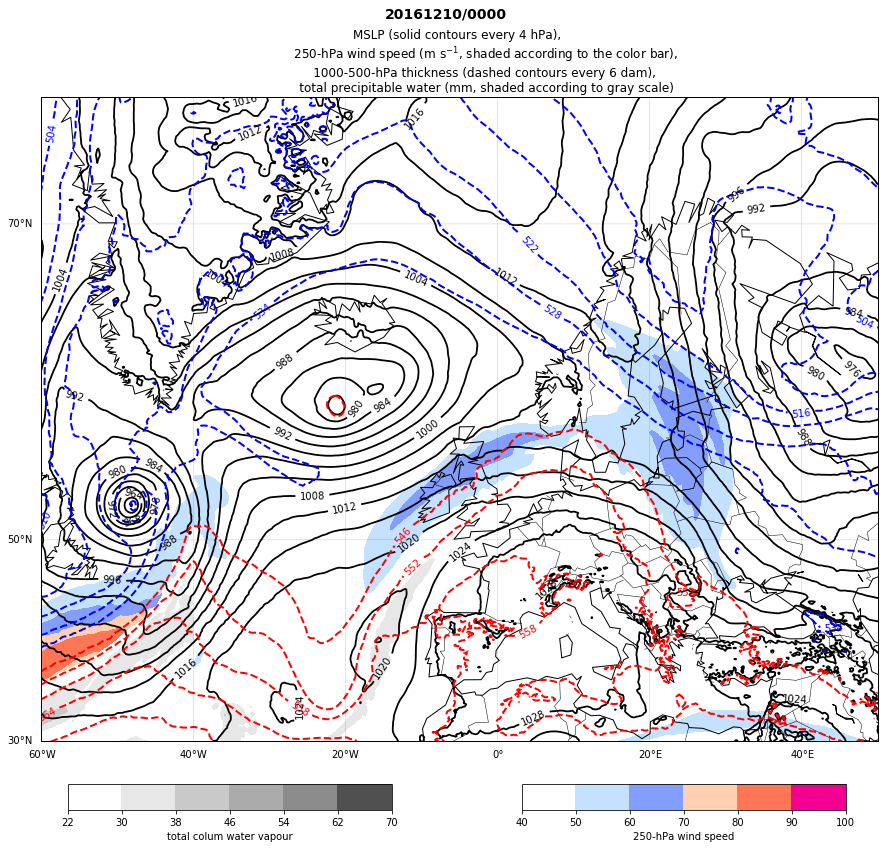

In [43]:
### PLOT FIGURE
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(1,1,1)

### Draw Latitude Lines
m.drawparallels(np.arange(-90.,120.,20.),labels=[1,0,0,0],fontsize=10,linewidth=0.2)

### Draw Longitude Lines
m.drawmeridians(np.arange(-180.,180.,20.),labels=[0,0,0,1],fontsize=10,linewidth=0.2)

### Draw Map
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
#m.fillcontinents(color='grey',alpha=0.1)


### Plot contour lines for 250-hPa wind and fill
Ulevels = np.arange(40,110,10)
Umap = colors.ListedColormap([no11, no12, no13, no14, no15, no16, no17])
norm = colors.BoundaryNorm(boundaries = Ulevels, ncolors=Umap.N)
cs = m.contourf(plonsUV, platsUV, Uabs, Ulevels, norm = norm, cmap=Umap)

### Plot MSL pressure every 4 hPa
clevs = np.arange(900,1100.,4.)
cc = m.contour(plonsMSL, platsMSL, MSL, clevs, colors='k', linewidths = 1.8)
plt.clabel(cc, fontsize=10, inline = 1, fmt ='%1.0f')

### Plot the 1000-500 hPa thickness
thlevs1 = np.arange(450., 540., 6.)
thlevs2 = np.arange(546., 650., 6.)

cth1 = m.contour(plonsZ, platsZ, Z, thlevs1, colors='b', linewidths = 2., linestyles = 'dashed')
cth2 = m.contour(plonsZ, platsZ, Z, thlevs2, colors='r', linewidths = 2., linestyles = 'dashed')
plt.clabel(cth1, fontsize = 10, inline = 1, fmt = '%1.0f')
plt.clabel(cth2, fontsize = 10, inline = 1, fmt = '%1.0f')

### Plot contour lines for precipitable water
PWlevs = np.arange(22.,78.,8.)
Pmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])
normP = colors.BoundaryNorm(boundaries = PWlevs, ncolors=Pmap.N)
cp = m.contourf(plonsPW, platsPW, PW, PWlevs, norm = normP, cmap = Pmap)

### Add Colorbar
cbaxes = fig.add_axes([0.57, 0.05, 0.3, 0.03]) 
cbar = plt.colorbar(cs,orientation='horizontal', cax = cbaxes)
cbar.ax.set_xlabel('250-hPa wind speed')


cbaxesP = fig.add_axes([0.15, 0.05, 0.3, 0.03]) 
cbarP = plt.colorbar(cp,orientation='horizontal', cax = cbaxesP)
cbarP.ax.set_xlabel('total colum water vapour')

### Add Title
#gribUV = 'test_data/pl/param_uv_%s%s%s.grib' % (year, mon, pred_date_time)    #20161210_0000.grib'


fig.suptitle('%s%s%s/%s' % (year, mon, date, time), fontsize=14, fontweight='bold') 
ax.set_title('MSLP (solid contours every 4 hPa), \n \
             250-hPa wind speed (m s$^{-1}$, shaded according to the color bar), \n \
             1000-500-hPa thickness (dashed contours every 6 dam), \n \
             total precipitable water (mm, shaded according to gray scale)')
#plt.title('') 

### Save
plt.savefig('../synoptic_figs/Jet_Thick_SLP_%s%s%s_%s.png' % (year, mon, date,time))
#plt.savefig('Jet_Thick_SLP.png') 


###
plt.show()